In [1]:
from utils.tram_models import *
from utils.tram_data import *
from utils.loss_continous import *
from sklearn.model_selection import train_test_split

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### fit and sample for 1 continous TRAM

Train size: 8000, Validation size: 1000, Test size: 1000


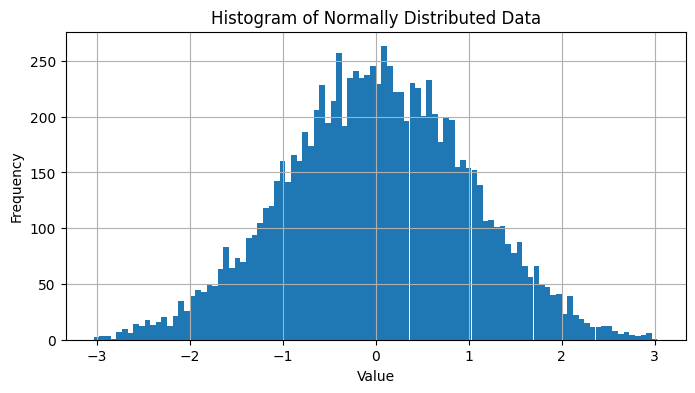

In [2]:
# Generate data
x1 = torch.randn(10_000)
df=pd.DataFrame(x1.numpy(), columns=['x1'])

min_max = np.quantile(x1, [0.05, 0.95])


# train
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
# Validation and test
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

hist = torch.histc(x1, bins=100, min=-3, max=3)
bins = torch.linspace(-3, 3, steps=100)
# Plot
plt.figure(figsize=(8, 4))
plt.bar(bins.numpy(), hist.numpy(), width=0.06, align='center')
plt.title("Histogram of Normally Distributed Data")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()





SI Model

In [3]:
tram_model=TramModel(SimpleIntercept())
tram_model

TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)

Dataloader

In [4]:
target_col='x1'
batch_size=1024


train_dataset = GenericDataset(train_df, target_col=target_col, data_type=None,  transform=None)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

val_dataset = GenericDataset(val_df, target_col=target_col, data_type=None,  transform=None)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

test_dataset = GenericDataset(test_df, target_col=target_col, data_type=None,  transform=None)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

for x,y in train_loader:
    print(x)
    print(y)
    break

[tensor([1., 1., 1.,  ..., 1., 1., 1.])]
tensor([ 0.9432, -0.6676,  1.5427,  ...,  1.6058, -0.5879,  0.0639])


Hyperparams

In [5]:
epochs = 500

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")

optimizer = torch.optim.Adam(tram_model.parameters(), lr=0.01, eps=1e-7, weight_decay=0.0)

Train with GPU support.


Train Model

In [7]:
TRAIN_AGAIN=False

checkpoint_path = '/home/bule/TramDag/weights/dev_x1/dev_x1.pt'  # File to save best weights

if TRAIN_AGAIN:
    train_loss_hist = []
    val_loss_hist = []
    best_val_loss = float('inf')  # Initialize with a high value

    for epoch in range(epochs):
        # === TRAIN ===
        tram_model.train()
        train_loss = 0.0

        for x, y in train_loader:
            x = [xi.to(device) for xi in x]
            y = y.to(device)

            optimizer.zero_grad()
            y_pred = tram_model(int_input=x[0].unsqueeze(1))  # (B,) -> (B,1)
            loss = contram_nll(y_pred, y, min_max=min_max)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_loss_hist.append(avg_train_loss)

        # === VALIDATION ===
        tram_model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = [xi.to(device) for xi in x_val]
                y_val = y_val.to(device)

                y_val_pred = tram_model(int_input=x_val[0].unsqueeze(1))
                loss_val = contram_nll(y_val_pred, y_val, min_max=min_max)
                val_loss += loss_val.item()

        avg_val_loss = val_loss / len(val_loader)
        val_loss_hist.append(avg_val_loss)

        # === SAVE MODEL IF BEST ===
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(tram_model.state_dict(), checkpoint_path)
            print(f"✓ Epoch {epoch+1:03d} | Val Loss Improved: {avg_val_loss:.4f} (Saved model)")

        else:
            print(f"Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
else:
    
    tram_model.load_state_dict(torch.load(checkpoint_path))
    tram_model.to(device)
    tram_model.eval()
    

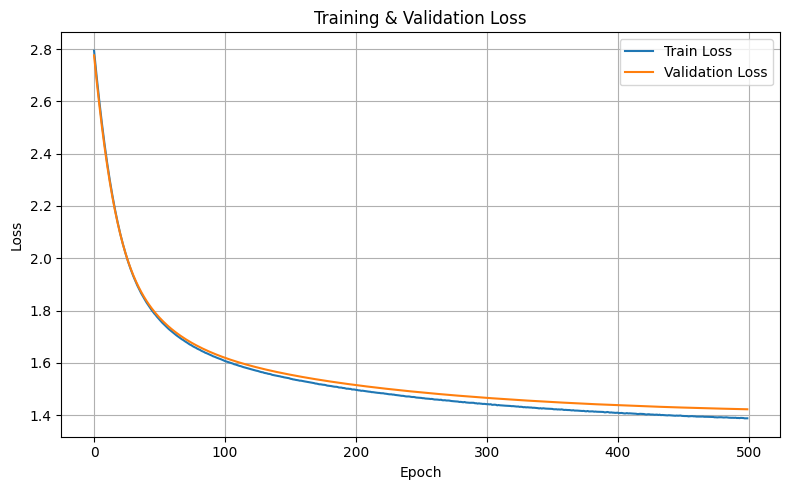

In [ ]:

plt.figure(figsize=(8, 5))
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


sample from latent var